In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import explained_variance_score

from lfpan import get_means
from utils import filter_expon
plt.style.use('pcb')

In [12]:
dt = 1e-4
mean_kdes, mean_lfps, tt = get_means(bw=0.005, span=(-1,8), dt=dt, cutoff=50)

In [16]:
%%time
N_tau = 20
N_shape = 17

taus = np.concatenate([np.logspace(-3, np.log10(3), N_tau)] * N_shape)
shapes = np.concatenate([np.ones(N_tau)*alpha for alpha in np.linspace(1, 5, N_shape)])

X_2 = np.array([filter_expon(mean_lfps[2], tau, shape, dt) for tau, shape in zip(taus, shapes)]).T
X_02 = np.array([filter_expon(mean_lfps[0.2], tau, shape, dt) for tau, shape in zip(taus, shapes)]).T
X_002 = np.array([filter_expon(mean_lfps[0.02], tau, shape, dt) for tau, shape in zip(taus, shapes)]).T

CPU times: user 1h 27min 44s, sys: 12.4 s, total: 1h 27min 56s
Wall time: 5min 16s


In [19]:
%%time

reg = LassoCV(normalize=True, tol=1e-3, max_iter=100000)

y = mean_kdes[2]

resp_mask = ((tt > -1) & (tt < 2))

reg.fit(X_2[resp_mask], y[resp_mask])
pred = reg.predict(X_2)
pred[pred < 0] = 0
score = explained_variance_score(y, pred)
print(score, reg.alpha_)

0.9826485074139509 0.00014034391678128746
CPU times: user 15min 39s, sys: 3.92 s, total: 15min 43s
Wall time: 52.6 s


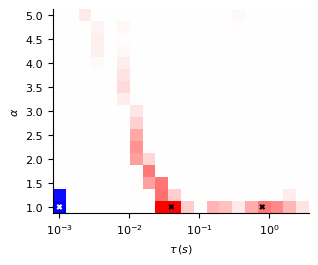

In [23]:
N_tau = 20
N_shape = 17

tau_expons = np.linspace(-3, np.log10(3), N_tau)
taus = np.logspace(-3, np.log10(3), N_tau)
shapes = np.linspace(1, 5, N_shape)

taus_arr = np.concatenate([taus] * N_shape)
shapes_arr = np.concatenate([np.ones(N_tau)*alpha for alpha in shapes])

dtau = tau_expons[1] - tau_expons[0]
dshape = shapes[1] - shapes[0]

vlim = 10

extent = [tau_expons[0]-dtau/2, tau_expons[-1]+dtau/2, shapes[0]-dshape/2, shapes[-1]+dshape/2]

fig, ax = plt.subplots(figsize=(2.2*1.5,1.8*1.5))

def plot_heatmap(ax, ms=10):
    ax.imshow(reg.coef_.reshape((N_shape,N_tau)), aspect='auto', cmap='bwr', vmin=-vlim, vmax=vlim, extent=extent, origin='lower')

    xticks = np.linspace(-3, 0., 4)
    ax.set_xticks(xticks)
    # ax.set_xticklabels([fr'$10^{{{x}}}$' for x in xticks])
    ax.set_xticklabels([fr'$10^{{{x:.0f}}}$' for x in xticks])
#     ax.set_xlabel(r'$\log_{10}\left[\tau\,\mathrm{(s)}\right]$')
    ax.set_xlabel(r'$\tau\,(s)$')
    ax.set_ylabel(r'$\alpha$')

    ax.scatter([-3, np.log10(0.04), np.log10(0.8)], [1,1,1], color=['white','black','black'], s=ms, marker='x')
    
plot_heatmap(ax)